# Summary

Reference:
- https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
- https://machinelearningmastery.com/calculate-feature-importance-with-python/
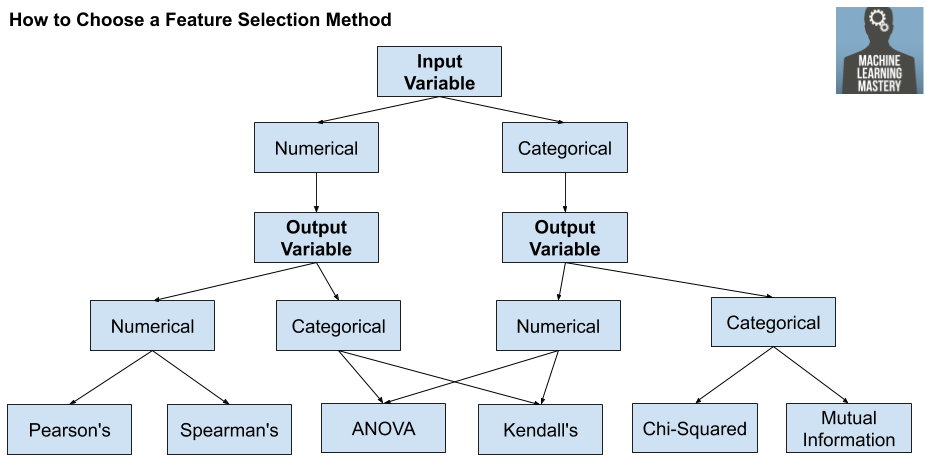

In [ ]:
import lib._util.visualplot as vp

# Feature Selection (Filtering)
from lib._class.DFVarianceThreshold import DFVarianceThreshold
from lib._class.DFDuplicateThreshold import DFDuplicateThreshold
from lib._class.DFCorrelationThreshold import DFCorrelationThreshold

# Feature Selection (Filtering - Classification)
from lib._class.DFMutualInfoClassifierThreshold import DFMutualInfoClassifierThreshold
from lib._class.DFANOVAClassifierThreshold import DFANOVAClassifierThreshold
from lib._class.DFChi2Threshold import DFChi2Threshold
from lib._class.DFROCAUCThreshold import DFROCAUCThreshold

# Feature Selection (Filtering - Regression)
from lib._class.DFMutualInfoRegressorThreshold import DFMutualInfoRegressorThreshold
from lib._class.DFANOVARegressorThreshold import DFANOVARegressorThreshold
from lib._class.DFMSEThreshold import DFMSEThreshold

# Feature Selection (Embedding - Classification)
from lib._class.DFLogisticRegressionSelector import DFLogisticRegressionSelector
from lib._class.DFRidgeClassifierSelector import DFRidgeClassifierSelector
from lib._class.DFDecisionTreeClassifierSelector import DFDecisionTreeClassifierSelector
from lib._class.DFExtraTreeClassifierSelector import DFExtraTreeClassifierSelector
from lib._class.DFRandomForestClassifierSelector import DFRandomForestClassifierSelector
from lib._class.DFXGBClassifierSelector import DFXGBClassifierSelector
from lib._class.DFCatBoostClassifierSelector import DFCatBoostClassifierSelector

# Feature selection (Embedding - Regression)
from lib._class.DFLinearRegressionSelector import DFLinearRegressionSelector
from lib._class.DFLassoSelector import DFLassoSelector
from lib._class.DFRidgeSelector import DFRidgeSelector
from lib._class.DFElasticNetSelector import DFElasticNetSelector
from lib._class.DFDecisionTreeRegressorSelector import DFDecisionTreeRegressorSelector
from lib._class.DFExtraTreeRegressorSelector import DFExtraTreeRegressorSelector
from lib._class.DFRandomForestRegressorSelector import DFRandomForestRegressorSelector
from lib._class.DFXGBRegressorSelector import DFXGBRegressorSelector
from lib._class.DFCatBoostRegressorSelector import DFCatBoostRegressorSelector

# Feature Selection (Wrapper)
from lib._class.DFSequentialFeatureSelector import DFSequentialFeatureSelector
from lib._class.DFExhaustiveFeatureSelector import DFExhaustiveFeatureSelector
from lib._class.DFRFECV import DFRFECV

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import DEFAULT_PLOTLY_COLORS

In [ ]:
OUT_PATH_GRAPH = 'resources/output/graph/'

def to_frame(X, y):
    data_df = pd.DataFrame(X, columns=[f'feature_{x+1}' for x in range(X.shape[1])])
    data_df['target'] = y
    
    new_X = data_df.drop(columns=['target']).copy()
    new_y = data_df['target'].copy()
    
    return new_X, new_y

def dataset_split(X, y, random_state=None):
    stratify = None if y.value_counts().min() == 1 else y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify, random_state=random_state)
    
    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

# 1. Classification

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Reference:
# - https://www.youtube.com/watch?v=VPZiJGNX4_s
# - https://www.youtube.com/watch?v=jJ7ff7Gcq34
# - https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
def eval_classif(X, y, model):
    y_pred = model.predict(X)
    y_true = y
    
    cofmat_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
    cofmat_df.index.name   = 'True'
    cofmat_df.columns.name = 'Pred'

    print(cofmat_df)
    print()
    print(classification_report(y_true, y_pred, digits=5))

In [ ]:
# Classification dataset
X_classif, y_classif = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=4,
    n_repeated=1,
    random_state=0
)
X_classif, y_classif = to_frame(X_classif, y_classif)

# Populate fake features
X_classif['constant'] = 1
X_classif['quasi_constant'] = np.where(X_classif.index <= 990, 1, 2)
X_classif['correlated'] = X_classif['feature_1'] * -1

X_classif.shape, y_classif.shape

In [ ]:
# Separate dataset
X_train, X_test, y_train, y_test = dataset_split(X_classif, y_classif, random_state=0)

print('Train dataset:')
vp.value_count(y_train.to_frame(), 'target')
print('\nTest dataset:')
vp.value_count(y_test.to_frame(), 'target')

In [ ]:
data_groups    = []
subplot_titles = []

## 1.1. Filtering Method

### 1.1.1. Quasi-Constant Feature
- Reference: https://www.youtube.com/watch?v=nPHU1CpX4jg&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=3&t=0s

In [ ]:
variance_threshold = DFVarianceThreshold(threshold=.01)

steps = [
    ('variance_threshold', variance_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train)

variance_threshold.stat_df

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.1.2. Duplicate Feature
- Reference: https://www.youtube.com/watch?v=nPHU1CpX4jg&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=3&t=0s

In [ ]:
variance_threshold  = DFVarianceThreshold(threshold=.01)
duplicate_threshold = DFDuplicateThreshold()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train)

duplicate_threshold.stat_df

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.1.3. Pearson Correlation Coefficients
- Reference: https://www.youtube.com/watch?v=m0fs0v5GGlg&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=3

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=.9)

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

correlation_threshold.stat_df

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.1.4. Mutual Information
- Reference: https://www.youtube.com/watch?v=GpL_XtRVne4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=4

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
mutual_info_threshold = DFMutualInfoClassifierThreshold(k=5)

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('mutual_info_threshold', mutual_info_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
mutual_info_threshold.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=mutual_info_threshold.stat_df['feature'],
            y=mutual_info_threshold.stat_df['average_score'],
            marker_color=np.where(mutual_info_threshold.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Mutual Information')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.1.5. Univariate ANOVA
- Reference: https://www.youtube.com/watch?v=PWZLhr3FfIM&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=6

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
anova_threshold       = DFANOVAClassifierThreshold()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('anova_threshold', anova_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
anova_threshold.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=anova_threshold.stat_df['feature'],
            y=anova_threshold.stat_df['average_score'],
            marker_color=np.where(anova_threshold.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Univariate ANOVA')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.1.6. Chi Square (χ2)
- Reference: https://www.youtube.com/watch?v=gDgEjdEzEDY&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=7

In [ ]:
from lib._class.DFPositiveTransformer import DFPositiveTransformer

In [ ]:
positive_transformer  = DFPositiveTransformer(columns=[x for x in X_train.columns])
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
chi2_threshold        = DFChi2Threshold()

steps = [
    ('positive_transformer', positive_transformer),
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('chi2_threshold', chi2_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
chi2_threshold.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=chi2_threshold.stat_df['feature'],
            y=chi2_threshold.stat_df['average_score'],
            marker_color=np.where(chi2_threshold.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Chi-Square')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.1.7. Univariate ROC-AUC
- Reference: https://www.youtube.com/watch?v=JEfBvK91CXc&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=5

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
rocauc_threshold      = DFROCAUCThreshold(threshold=.5)

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('rocauc_threshold', rocauc_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
rocauc_threshold.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=rocauc_threshold.stat_df['feature'],
            y=rocauc_threshold.stat_df['average_score'],
            marker_color=np.where(rocauc_threshold.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Univariate ROC-AUC')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

## 1.2. Embedded Method

### 1.2.1. Logistic Regression

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFLogisticRegressionSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Logistic Regression')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.2.2. Ridge Classifier

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFRidgeClassifierSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Ridge Classifier')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.2.3. Decision Tree Classifier 

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFDecisionTreeClassifierSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Decision Tree Classifier')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.2.4. Extra Tree Classifier

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFExtraTreeClassifierSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Extra Tree Classifier')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.2.5. Random Forest Classifier

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFRandomForestClassifierSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Random Forest Classifier')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.2.6. XGBoost Classifier

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFXGBClassifierSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('XGBoost Classifier')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.2.7. CatBoost Classifier

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFCatBoostClassifierSelector(
                            cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1),
                            iterations=1000,
                            early_stopping_rounds=200,
                            verbose=500,
                            task_type='GPU',
                            eval_metric='AUC', # https://catboost.ai/docs/concepts/python-reference_utils_eval_metric.html
                            loss_function='CrossEntropy',
                            cat_features=None
                        )

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

steps = [
    ('selector', selector),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train_, y_train,
                                          selector__use_best_model=True,
                                          selector__eval_set=(X_test_, y_test))

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('CatBoost Classifier')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

###### Bar

In [ ]:
vp.datagroups_subplots(
    data_groups,
    max_col=2,
    title='Classification',
    out_path=OUT_PATH_GRAPH,
    subplot_kwargs={
        'subplot_titles': subplot_titles,
        'vertical_spacing': .06
    },
    layout_kwargs={
        'height': 1500,
        'showlegend': False
    })

## 1.3. Wrapper Method
- Reference: https://www.youtube.com/watch?v=zW1SvA0Z-l4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=8

### 1.3.1. Step Forward Selection (SFS)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFSequentialFeatureSelector(
                            estimator=RandomForestClassifier(random_state=0, n_jobs=-1),
                            k_features=8,
                            forward=True,
                            floating=False,
                            verbose=2,
                            scoring='roc_auc',
                            cv=StratifiedKFold(5),
                            n_jobs=-1
                        )

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

selector.stat_df.sort_values(by='avg_score', ascending=False)

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.3.2. Step Backward Selection (SBS)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFSequentialFeatureSelector(
                            estimator=RandomForestClassifier(random_state=0, n_jobs=-1),
                            k_features=2,
                            forward=False,
                            floating=False,
                            verbose=2,
                            scoring='roc_auc',
                            cv=StratifiedKFold(5),
                            n_jobs=-1
                        )

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

selector.stat_df.sort_values(by='avg_score', ascending=False)

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.3.3. Exhaustive Feature Selection (EFS)
- No. of Combinations = C(N_features, min_N_features) + C(N_features, max_N_features)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFExhaustiveFeatureSelector(
                            estimator=RandomForestClassifier(random_state=0, n_jobs=-1),
                            min_features=5,
                            max_features=8,
                            print_progress=True,
                            scoring='roc_auc',
                            cv=StratifiedKFold(5),
                            n_jobs=-1
                        )

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

selector.stat_df.sort_values(by='avg_score', ascending=False)

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 1.3.4. Recursive Feature Elimination + Cross Validation (RFECV)
- Reference:
  - https://machinelearningmastery.com/feature-selection-with-categorical-data/
  - https://www.youtube.com/watch?v=pcZ4YlvhSKU&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=10
  - https://www.youtube.com/watch?v=7062skdX05Y

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFRFECV(
                            estimator=RandomForestClassifier(random_state=0, n_jobs=-1),
                            verbose=2,
                            scoring='roc_auc',
                            cv=StratifiedKFold(5),
                            n_jobs=-1
                        )

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

selector.stat_df.sort_values(by='ranking')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

# 2. Regression

In [ ]:
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Reference: https://medium.com/acing-ai/how-to-evaluate-regression-models-d183b4f5853d
def eval_regress(X, y, model):
    y_pred = model.predict(X_test)
    y_true = y
    
    print(f'MAE:      {mean_absolute_error(y_true, y_pred) :.5f}')
    print(f'R2 Score: {r2_score(y_true, y_pred) :.5f}')
    print(f'RMSE:     {np.sqrt(mean_squared_error(y_true, y_pred)) :.5f}')

In [ ]:
X_regress, y_regress = make_regression(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    random_state=0
)
X_regress, y_regress = to_frame(X_regress, y_regress)

X_regress.shape, y_regress.shape

In [ ]:
# Separate dataset
X_train, X_test, y_train, y_test = dataset_split(X_regress, y_regress, random_state=0)

X_train.shape, X_test.shape

In [ ]:
data_groups    = []
subplot_titles = []

## 2.1. Filtering Method

### 2.1.1. Mutual Information

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
mutual_info_threshold = DFMutualInfoRegressorThreshold(k=5)

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('mutual_info_threshold', mutual_info_threshold)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
mutual_info_threshold.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=mutual_info_threshold.stat_df['feature'],
            y=mutual_info_threshold.stat_df['average_score'],
            marker_color=np.where(mutual_info_threshold.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Mutual Information')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.1.2. Univariate ANOVA

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
anova_threshold       = DFANOVARegressorThreshold()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('anova_threshold', anova_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
anova_threshold.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=anova_threshold.stat_df['feature'],
            y=anova_threshold.stat_df['average_score'],
            marker_color=np.where(anova_threshold.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Univariate ANOVA')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.1.3 Univariate MSE
- Reference: https://www.youtube.com/watch?v=JEfBvK91CXc&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=5

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
mse_threshold         = DFMSEThreshold(k=5)

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('mse_threshold', mse_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
mse_threshold.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=mse_threshold.stat_df['feature'],
            y=mse_threshold.stat_df['average_score'],
            marker_color=np.where(mse_threshold.stat_df['k_support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Univariate MSE')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

## 2.2. Embedded Method

### 2.2.1. Linear Regression

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFLinearRegressionSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Linear Regression')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.2. Lasso (L1 Regularization)
- Reference:
  - https://www.youtube.com/watch?v=gryKjGVgzc4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=9
  - https://www.youtube.com/watch?v=w3-g6YYANDQ

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFLassoSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Lasso')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.3. Ridge (L2 Regularization)
- Reference: https://www.youtube.com/watch?v=gryKjGVgzc4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=9

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFRidgeSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Ridge')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.4. Elastic Net (L1 + L2 Regularization)

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFElasticNetSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Elastic Net')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.5. Decision Tree Regressor

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFDecisionTreeRegressorSelector(k=5)

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Decision Tree Regressor')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.6. Extra Tree Regressor

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFExtraTreeRegressorSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Extra Tree Regressor')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.7. Random Forest Regressor

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFRandomForestRegressorSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('Random Forest Regressor')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.8. XGBoost Regressor

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFXGBRegressorSelector()

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
    ('selector', selector)
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('XGBoost Regressor')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

### 2.2.9. CatBoost Regressor

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
variance_threshold    = DFVarianceThreshold(threshold=.01)
duplicate_threshold   = DFDuplicateThreshold()
correlation_threshold = DFCorrelationThreshold(threshold=1)
selector              = DFCatBoostRegressorSelector(
                            cv=RepeatedKFold(n_splits=5, n_repeats=1),
                            iterations=1000,
                            early_stopping_rounds=200,
                            verbose=500,
                            task_type='GPU',
                            eval_metric='RMSE', # https://catboost.ai/docs/concepts/python-reference_utils_eval_metric.html
                            loss_function='RMSE',
                            cat_features=None
                        )

steps = [
    ('variance_threshold', variance_threshold),
    ('duplicate_threshold', duplicate_threshold),
    ('correlation_threshold', correlation_threshold),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train, y_train)
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

steps = [
    ('selector', selector),
]
pipeline = Pipeline(steps, verbose=2).fit(X_train_, y_train,
                                          selector__use_best_model=True,
                                          selector__eval_set=(X_test_, y_test))

# Graph data
selector.stat_df.sort_values(by='feature', inplace=True)
fig = go.Figure(
    data=[go.Bar(
            x=selector.stat_df['feature'],
            y=selector.stat_df['average_score'],
            marker_color=np.where(selector.stat_df['support'],
                                  DEFAULT_PLOTLY_COLORS[2], DEFAULT_PLOTLY_COLORS[3])
    )]
)
data_groups.append(fig['data'])
subplot_titles.append('CatBoost Regressor')

In [ ]:
X_train_ = pipeline.transform(X_train)
X_test_  = pipeline.transform(X_test)

X_train_.shape, X_test_.shape

###### Bar

In [ ]:
vp.datagroups_subplots(
    data_groups,
    max_col=2,
    title='Regression',
    out_path=OUT_PATH_GRAPH,
    subplot_kwargs={
        'subplot_titles': subplot_titles,
        'vertical_spacing': .06
    },
    layout_kwargs={
        'height': 1500,
        'showlegend': False
    })